#

# Compute area

### path and inputs

In [3]:
cd "C:\\Code\\ditto_v2"

C:\Code\ditto_v2


In [4]:
%pwd

'C:\\Code\\ditto_v2'

In [15]:
# Define the center point and radius
lat, lon = 50.0, 10.0  # Example coordinates
radius_km = 30
radius = radius_km * 1000  # Convert km to meters

### 

<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\D'
C:\Users\User\AppData\Local\Temp\ipykernel_13216\2671012487.py:5: SyntaxWarning: invalid escape sequence '\D'
  gdf_de = gpd.read_file('JupNB\DE_Data\VG250_GEM_WGS84.shp')


shape=(1, 30)


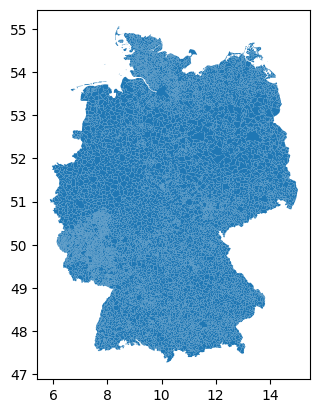

In [ ]:
from shapely.geometry import Point
import geopandas as gpd

## GeoDataFrame with Germany's state boundaries
gdf_de = gpd.read_file('JupNB\DE_Data\VG250_GEM_WGS84.shp')


# Create a point object
point = Point(lon, lat)

result = gdf_de.geometry.contains(point)
gdf_point = gdf_de[result]

if gdf_point.empty:
    print('No data found')
else:
    print(f'shape={gdf_point.shape}')
    
# Plots
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# gdf_circle.plot(ax=ax, color='red', alpha=0.5)
gdf_de.plot(ax=ax)
plt.show()

In [20]:
import folium

def get_fg(point1, radius, epsg, color='blue') -> folium.FeatureGroup:
    gdf_point = gpd.GeoDataFrame(geometry=[point1], crs=f'EPSG:4326')

    gdf_point_epsg = gdf_point.to_crs(epsg=epsg) 
    gdf_circle = gdf_point_epsg.buffer(radius)
    gdf_circle = gpd.GeoDataFrame(geometry=gdf_circle)
    gdf_circle = gpd.GeoDataFrame(geometry=gdf_point.buffer(radius))

    fg_circle = folium.FeatureGroup(name=f'EPSG {epsg} [r={radius} m \
                                    color = "red" \
                                    area = {round (gdf_circle.geometry.area.sum() / 10**6, 2)} Km2]')
    gjson_circle = folium.GeoJson(gdf_circle, color=color)
    gjson_circle.add_to(fg_circle)    
    return fg_circle



In [ ]:
# import pandas as pd
# pd.set_option('display.max_columns', None)

# gdf_circle.head(2)

,OBJID,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,IBZ,...,PERC_int,EWZ_int,EWZ_out,EWZ_sum,EWZ_ref,EWZ_perc,KFL_sum,KFL_out,KFL_ref,KFL_perc


In [470]:
from functools import partial
import pyproj
from shapely.geometry import Point
from shapely.ops import transform
from pyproj import Transformer

def transform_wgs84_aeqd(lon, lat) :
    point_transformed =Transformer.from_crs(4326, 3857, always_xy=True).transform(float(lat),float(lon))
    return point_transformed

def transform_aeqd_wgs84(y,x) :
    point_transformed = Transformer.from_crs(3857, 4326, always_xy=True).transform(y,x)
    return point_transformed

# create a circle with a specified radius in meters around a point defined using latitude and longitude
def circle_around_lat_lon_point(lon, lat, radius) : 
    # lon, lat = 0, 42  # Example coordinates for San Francisco
    # radius = 30000  # Radius in meters

    local_azimuthal_projection = "+proj=aeqd +R=6371000 +units=m +lat_0={} +lon_0={}".format(lat, lon)
    wgs84_to_aeqd = partial(pyproj.transform, pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"), pyproj.Proj(local_azimuthal_projection))
    aeqd_to_wgs84 = partial(pyproj.transform, pyproj.Proj(local_azimuthal_projection), pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"))

    center = Point(float(lon), float(lat))
    point_transformed = transform(wgs84_to_aeqd, center)
    # print(f'x{point_transformed.x}, y={point_transformed.y}')
    buffer = point_transformed.buffer(radius)
    circle_poly = transform(aeqd_to_wgs84, buffer)
    return circle_poly

In [486]:
center_point.y, center_point.x

(51.0, 10.0)

In [602]:
from geopy.distance import geodesic


def compute_dist_to_lat_lon(gdf,lon,lat,col_out:str='dist',units:str='km',round_dec:int=2):
    point_of_interest = (lat,lon)
    if units == 'km':
        gdf[col_out] = gdf.geometry.apply(
            lambda row: geodesic(point_of_interest, (row.y, row.x)).kilometers)
    elif units == 'm':
        gdf[col_out] = gdf.geometry.apply(
            lambda row: geodesic(point_of_interest, (row.y, row.x)).meters)
    elif units == 'mi':
        gdf[col_out] = gdf.geometry.apply(
            lambda row: geodesic(point_of_interest, (row.y, row.x)).miles)
    else:
        raise ValueError("units must be one of the following [km,m,mi]")
    gdf[col_out] = round(gdf[col_out], round_dec)
    return gdf

In [579]:
center_point.y

51.0

In [603]:
import pandas as pd
gdf = pd.DataFrame(dict_uni[4326]['gdf'][['ARS','lat','lon']])
geometry = [Point(xy) for xy in zip(gdf['lon'], gdf['lat'])]
gdf = gpd.GeoDataFrame(gdf, crs='epsg:4326', geometry=geometry)
gdf = compute_dist_to_lat_lon(gdf,lat=center_point.y, lon=center_point.x)
gdf

,ARS,lat,lon,geometry,dist
0,066310007007,50.764393,9.815881,POINT (9.81588 50.76439),29.24
1,066310022022,50.717124,9.897403,POINT (9.8974 50.71712),32.29
2,066320001001,51.028815,9.659455,POINT (9.65946 51.02881),24.11
3,066320002002,50.865028,9.701212,POINT (9.70121 50.86503),25.82
4,066320003003,50.977940,9.815296,POINT (9.8153 50.97794),13.20
...,...,...,...,...,...
78,160645053032,51.118561,10.414555,POINT (10.41455 51.11856),31.92
79,160645053053,51.134500,10.412523,POINT (10.41252 51.1345),32.56
80,160645053075,51.159551,10.394271,POINT (10.39427 51.15955),32.84
81,160645054076,51.124963,10.511099,POINT (10.5111 51.12496),38.43


In [565]:
point_of_interest = (51,10)

In [ ]:
from geopy.distance import geodesic

# Example of calculating geodesic distance for each row
gdf['dist'] = gdf.geometry.apply(
    lambda row: geodesic(point_of_interest, (row.y, row.x)).meters)
gdf


TypeError: 'Point' object is not subscriptable

In [569]:
gdf = gdf.sort_values('dist')
gdf

,ARS,lat,lon,geometry,dist
13,066320013013,51.008914,9.941369,POINT (9.94137 51.00891),4233.157853
20,066320020020,50.954055,9.979089,POINT (9.97909 50.95406),5318.048294
34,066360011011,51.068537,9.952451,POINT (9.95245 51.06854),8322.268296
29,066360005005,51.028286,10.127375,POINT (10.12737 51.02829),9476.404599
57,160630103103,50.923672,10.085388,POINT (10.08539 50.92367),10396.597736
...,...,...,...,...,...
21,066340011011,50.995634,9.512888,POINT (9.51289 50.99563),34199.109621
8,066320008008,50.764179,9.672163,POINT (9.67216 50.76418),34936.037707
11,066320011011,50.853192,9.553540,POINT (9.55354 50.85319),35384.289842
15,066320015015,50.801919,9.603995,POINT (9.60399 50.80192),35519.397452


In [567]:
print(f'max={gdf['dist'].max()}\n min={gdf['dist'].min()}')

max=38432.16774645152
 min=4233.157852615904


In [557]:
from geopy.distance import geodesic
newport_ri = (51,10)
cleveland_oh = (50.764393, 9.815881)
print(geodesic(newport_ri, cleveland_oh).kilometers)
# 538.390445368

29.23825408683935


In [547]:

# Create a GeoDataFrame with the geometry column from the latitude and longitude columns
gdf = gpd.GeoDataFrame(
    gdf_gem_points, 
    geometry=gpd.points_from_xy(gdf_gem_points.x_aeqd, gdf_gem_points.y_aeqd), 
    crs="EPSG:3857"
)
center_point_aeqd = transform_wgs84_aeqd(lon=center_point.x, lat=center_point.y)
target_point_aeqd = Point(center_point_aeqd[0], center_point_aeqd[1])


gdf_gem_points['dist'] = gdf.geometry.apply(lambda point: point.distance(target_point_aeqd)) / 10**3
gdf_gem_points = gdf_gem_points.sort_values('dist')
gdf_gem_points

,ARS,lat,lon,center_aeqd,x_aeqd,y_aeqd,distance_to_target,dist
20,066320020020,50.954055,9.979089,"(5672179.507388541, 1116526.291213427)",5.672180e+06,1.116526e+06,6.444614e+06,5.634301
13,066320013013,51.008914,9.941369,"(5678286.327284412, 1112263.1131833836)",5.678286e+06,1.112263e+06,6.451946e+06,6.700742
34,066360011011,51.068537,9.952451,"(5684923.518678747, 1113515.5482033575)",5.684924e+06,1.113516e+06,6.455752e+06,9.332393
9,066320009009,50.890981,9.973651,"(5665158.117425599, 1115911.6335151873)",5.665158e+06,1.115912e+06,6.440090e+06,12.496035
57,160630103103,50.923672,10.085388,"(5668797.268467533, 1128543.2493460304)",5.668797e+06,1.128543e+06,6.433723e+06,12.860042
...,...,...,...,...,...,...,...,...
15,066320015015,50.801919,9.603995,"(5655243.720718223, 1074153.7276312537)",5.655244e+06,1.074154e+06,6.462771e+06,49.875324
11,066320011011,50.853192,9.553540,"(5660951.474174023, 1068457.7411221087)",5.660951e+06,1.068458e+06,6.470834e+06,53.014049
54,160630098098,51.008646,10.480566,"(5678256.551915112, 1173252.427122398)",5.678257e+06,1.173252e+06,6.408917e+06,54.370973
21,066340011011,50.995634,9.512888,"(5676808.041308723, 1063868.9939286613)",5.676808e+06,1.063869e+06,6.485238e+06,55.023127


In [541]:
print(f'max={gdf_gem_points['dist'].max()}\n min={gdf_gem_points['dist'].min()}')

max=59.46913153409964
 min=5.6343008961841345


In [ ]:
# Convert the DataFrame to a GeoDataFrame using the points_from_xy method

gdf = gpd.GeoDataFrame(gdf_gem_points, geometry=gpd.points_from_xy(gdf_gem_points.lon, gdf_gem_points.lat, crs='EPSG:4326'))
targe_point = Point(center_point.y, center_point.x)

center_point_aeqd = transform_wgs84_aeqd(lon=center_point.x, lat=center_point.y)
target_point_aeqd = Point(center_point_aeqd[1], center_point_aeqd[0])
# Convert the GeoDataFrame to a local coordinate system (e.g., EPSG:32643 for UTM zone 43N)
gdf = gdf.to_crs('EPSG:3857')

# Calculate the distance of each point in the GeoDataFrame to the target point
gdf['distance_to_target'] = gdf.geometry.apply(lambda point: point.distance(target_point_aeqd))
gdf

# # Now the 'distance_to_target' column in gdf contains the distances in meters

# gdf_gem_points['center_aeqd'] = gdf_gem_points.apply(lambda row: transform_wgs84_aeqd(row['lon'], row['lat']), axis=1)



# center_point_aeqd = transform_wgs84_aeqd(lon=center_point.x, lat=center_point.y)
# print(f'center_point_aeqd={center_point_aeqd}')
# print(f'gdf_gem_points={gdf_gem_points}')

# # Assuming you have a GeoDataFrame with points
# gdf = gpd.GeoDataFrame({'geometry': [Point(12.9336806, 77.6122669), Point(12.974768, 77.767745), ...]})

# gdf_gem_points['distance_to_target'] = gdf_gem_points.geometry.apply(lambda point: point.distance(center_point_aeqd))
# # distances = gdf_de_int_3857.geometry.distance(gdf_point_3857)

# # # Add the distances as a new column in the GeoDataFrame
# # gdf_de_int['distance_km'] = round(distances / 10**6,3)

# # gdf_de_int['dist_km'] = gdf_de_int.apply(lambda row: Point(row.longitude, row.latitude), axis=1)
# gdf_gem_points.head()

,ARS,lat,lon,center_aeqd,geometry,distance_to_target
0,066310007007,50.764393,9.815881,"(5651066.413354365, 1098083.6198510984)",POINT (1092698.879 6579722.969),7.130162e+06
1,066310022022,50.717124,9.897403,"(5645804.387505143, 1107294.54771753)",POINT (1101773.845 6571407.901),7.117959e+06
2,066320001001,51.028815,9.659455,"(5680501.673972262, 1080415.8293747911)",POINT (1075285.643 6626392.302),7.177121e+06
3,066320002002,50.865028,9.701212,"(5662269.012844227, 1085131.3583841473)",POINT (1079934.029 6597453.371),7.151949e+06
4,066320003003,50.977940,9.815296,"(5674838.314636487, 1098017.5311664832)",POINT (1092633.758 6617392.479),7.159095e+06
...,...,...,...,...,...,...
78,160645053032,51.118561,10.414555,"(5690492.180071233, 1165780.2101910163)",POINT (1159342.909 6642292.646),7.135815e+06
79,160645053053,51.134500,10.412523,"(5692266.487403044, 1165550.2340338004)",POINT (1159116.721 6645119.765),7.138147e+06
80,160645053075,51.159551,10.394271,"(5695055.217200709, 1163484.5616514594)",POINT (1157085.007 6649565.203),7.142875e+06
81,160645054076,51.124963,10.511099,"(5691204.8213626, 1176709.2406938327)",POINT (1170090.221 6643428.027),7.129895e+06


In [513]:
print(f'max={gdf['distance_to_target'].max()}\n min={gdf['distance_to_target'].min()}')

max=7197833.822010541
 min=7095065.679060448


In [505]:
center_point_aeqd = transform_wgs84_aeqd(lon=center_point.x, lat=center_point.y)
center_point_aeqd

(5677294.030456952, 1118889.9748579594)

In [472]:
lon_point = 0.0
lat_point = 42.0
p = transform_wgs84_aeqd(lon=lon_point, lat=lat_point)
q = transform_aeqd_wgs84(p[0],p[1])
r = circle_around_lat_lon_point(42,0,10000)
print(f'lat={lat_point}, lon={lon_point}')
print(f'p={p}')
print(f'q={q}')

print(f'r={r}')

lat=42.0, lon=0.0
p=(4675418.613317491, 0.0)
q=(42.0, 0.0)
r=POLYGON ((42.08993216059187 0, 42.0894991133638 -0.0088148896201318, 42.08820414210029 -0.0175448872394922, 42.086059717905314 -0.0261059183960312, 42.08308649247783 -0.0344155358333172, 42.07931309924853 -0.0423937134994639, 42.07477587765494 -0.0499636172325818, 42.06951852320737 -0.057052344711423, 42.06359166671288 -0.0635916275454628, 42.057052386706594 -0.0695184887428319, 42.0499636597828 -0.0747758492238051, 42.04239375411725 -0.0793130775378761, 42.034415572019306 -0.0830864774891062, 42.02610594784458 -0.0860597089722024, 42.01754490802945 -0.0882041379649079, 42.00881490037437 -0.0894991123045966, 42 -0.0899321605918731, 41.99118509962563 -0.0894991123045966, 41.98245509197055 -0.0882041379649079, 41.97389405215542 -0.0860597089722024, 41.965584427980694 -0.0830864774891062, 41.95760624588275 -0.0793130775378761, 41.9500363402172 -0.0747758492238051, 41.94294761329341 -0.0695184887428319, 41.93640833328712 -0.06359

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return type(geom)(zip(*func(*zip(*geom.coords))))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))


(0.0, 5160979.444049781)

In [452]:
from pyproj import Transformer, CRS

lat = 42
lon = 0
print(f'{lat}, {lon}')

transformer = Transformer.from_crs(4326, 3857, always_xy=True)#, always_xy=True)
point_3857 =transformer.transform(lat,lon)
print(point_3857)

transformer2 = Transformer.from_crs(3857, 4326, always_xy=True)
point_wgs84 = transformer2.transform(point_3857[0], point_3857[1])
print(point_wgs84)


gdf_p = gpd.GeoDataFrame(geometry=[Point(lat,lon)], crs=f'EPSG:4326')
print(gdf_p)
gdf_q = gdf_p.to_crs(3857)
print(gdf_q)
gdf_r = gdf_q.to_crs(4326)
print(gdf_r)

42, 0
(4675418.613317491, 0.0)
(42.0, 0.0)
       geometry
0  POINT (42 0)
                geometry
0  POINT (4675418.613 0)
       geometry
0  POINT (42 0)


In [592]:
l_epsg = [
    # 6933, 
        #   3857,    ## metric coordinate system 
        #   3310,
          4326,
]
l_color = ['green', 
           'red',
           'black'
           ]
l_cols_non_serializable = [
    # 'centroid',  # Geometry Points
    'WSK','BEGINN', # Datetimes
]


lat = 51
lon = 10
radius = 30000

dict_gdf_de = {}

for epsg in l_epsg:
    gdf_epsg = gdf_de.to_crs(epsg=4326)
    
    if epsg == 4326:
        epsg_proj = 6933
    else:
        epsg_proj = epsg

    gdf_projected = gdf_epsg.to_crs(epsg=6933)
    gdf_epsg['KFL_GPD'] = round(gdf_projected.geometry.area / 10**6, 2)

    gdf_epsg = gdf_epsg.to_crs(epsg=4326)
    
    # gdf_epsg['centroid'] = gdf_epsg.geometry.centroid
    gdf_epsg['lat'] = gdf_epsg.geometry.centroid.y
    gdf_epsg['lon'] = gdf_epsg.geometry.centroid.x


    gdf_epsg = gdf_epsg.to_crs(epsg=epsg_proj)
    dict_gdf_de[epsg] = gdf_epsg

# # Compute the centroid of each geometry
# gdf_de['centroid'] = gdf_de['geometry'].centroid
# # Extract latitude and longitude from the Point geometries
# gdf_de['lon'] = gdf_de['geometry'].centroid.x
# gdf_de['lat'] = gdf_de['geometry'].centroid.y
# # dict_gdf_de[3857] = gdf_de.to_crs(epsg=3857)

C:\Users\User\AppData\Local\Temp\ipykernel_13216\417423299.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_epsg['lat'] = gdf_epsg.geometry.centroid.y
C:\Users\User\AppData\Local\Temp\ipykernel_13216\417423299.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_epsg['lon'] = gdf_epsg.geometry.centroid.x


In [604]:
import folium.features
from pyproj import CRS
from shapely import geometry
import folium
from src.functionality_maps import f_maps

dict_epsg = {}


center_point = geometry.Point(lon, lat)
gdf_point = gpd.GeoDataFrame(geometry=[center_point], crs=f'EPSG:4326')
fg_point = folium.FeatureGroup(name=f'Center point [lat={lat}, lon={lon}]')
gjson_point = folium.Marker([center_point.y, center_point.x], 
                            icon=folium.Icon(color="red"),
                            tooltip=folium.features.GeoJsonTooltip(fields=['geometry'], values=['coordinates'])
                            )

gjson_point.add_to(fg_point)

gdf = gpd.GeoDataFrame(geometry=[center_point], crs=CRS.from_epsg(4326))
# circle_30k_4326 = gdf.buffer(radius_m)
for epsg,color in zip(l_epsg,l_color):
    dict_epsg[epsg] = {}

    if epsg != 4326:
        gdf_point_epsg = gdf_point.to_crs(epsg=epsg)
        gdf_circle = gdf_point_epsg.buffer(radius)
    
        gdf_circle = gpd.GeoDataFrame(geometry=gdf_circle)

    else:
        ############# CIRCLE PROJECTION IN 4326 ####################
        # Convert the Shapely circle to a geoDataFrame
        poly_circle = circle_around_lat_lon_point(lon, lat, radius=radius)
        gdf = gpd.GeoSeries([poly_circle])
        gdf_circle = gdf.to_frame(name='geometry').set_crs(epsg=epsg)
        gdf_circle['area'] = round(gdf_circle.to_crs(epsg=3857).geometry.area.sum() / 10**6, 2)


    dict_epsg[epsg]['gdf']= gdf_circle

    fg_circle = folium.FeatureGroup(name=f'EPSG {epsg} [r={radius_km} Km \
                                    color = {color} \
                                    area = {round (gdf_circle.geometry.area.sum() / 10**6, 2)} Km2]')
    
    gjson_circle = folium.GeoJson(gdf_circle, color=color)
    gjson_circle.add_to(fg_circle)

    dict_epsg[epsg]['fg'] = fg_circle

        # # Generate FeatureGroup and add geojson
        # fg_circle = folium.FeatureGroup(name=f'EPSG={epsg} [r={radius_km} Km \
        #                                 color = "black", \
        #                                 area = {gdf['area'].sum()} Km2]')
        # folium.GeoJson(gdf, color='black').add_to(fg_circle)

        # dict_epsg[epsg]= {'gdf' : gdf, 'fg' : fg_circle}

############ CONTAINS POINT ############
dict_op = {}
result = gdf_de.geometry.contains(center_point)     
# Find the geometry that contains a point
gdf_de_point = gdf_de[result]                       
# # Create a GeoDataFrame with the point
gdf_de_point = gdf_de_point.drop(l_cols_non_serializable, axis=1) 
# Remove timestamp columns (not serializable)

fgc = f_maps.get_folium_featuregroup(gdf_de_point, fg_name=f'Container point [{center_point}]',
                                    fields=['GEN', 'EWZ', 'KFL', 'AGS'],
                                    aliases = ['Name', 'Population', 'Area', 'AGS'])

dict_op['contains'] = {'fg' : fgc}

# ############ GEOMETRY INTERSECTION ############\n
# Find the intersection
print('Finding the intersections')
dict_int = {}
for epsg in l_epsg:

    print(f'epsg={epsg}')
    gdf_de_int = gpd.sjoin(dict_gdf_de[epsg].to_crs(epsg=epsg), dict_epsg[epsg]['gdf'].to_crs(epsg=epsg), 
                        how="inner", predicate="intersects") \
                            .drop(l_cols_non_serializable, axis=1) 
    print(f' shape={gdf_de_int.shape[0]}')
    # Calculate the distance between each point in gdf and the other point
    # distances = gdf_de_int.geometry.distance(center_point)
    # print(gdf_de_int)
    # gdf_de_int = gdf_de_int.to_crs(epsg=3310, inplace=True)
    # distances = gdf_de_int.geometry.apply(lambda g: center_point.distance(g))
    
#     # # Add the distances as a new column in the GeoDataFrame\n    
#     # gdf_de_int['stance_km'''round(distances / 10**6,3)\n    
#     # # gdf_de_int = gdf_de_int.to_crs(epsg=epsg)\n\n    
    fgi = f_maps.get_folium_featuregroup(gdf_de_int, 
                                        fg_name=f'Intersection EPSG={epsg} [#={gdf_de_int.shape[0]}]',
                                        #  A={round(gdf_de_int.geometry.area.sum() / 10**6,2)} Km2, \                           
                                        #  A_data={gdf_de_int.KFL.sum()} Km2]',
                                        fields=['GEN', 'EWZ', 'KFL', 'KFL_GPD', 'AGS'
                                                #  'lat', 'lon'
                                                # 'distance_km'      
                                                ],
                                        aliases = ['Name', 'Population', 'Area', 'Area_GPD','AGS',
                                                            # 'lat', 'lon''   '  '   ''   '  '   '                  
                                                            #    'Distance [Km]''            ' '             '                 
                                                    ])   
    dict_int[epsg] = {'fg' : fgi, 'gdf':gdf_de_int}

# ##'###### GEOMETRY UNION ############
# Find the union
dict_uni = {}
dict_cir_merged = {}
dict_gem_inside = {}
dict_gem_partly = {}
for epsg in l_epsg:
    # if epsg == 4326:
    epsg_proj = 6933
    # else:
    #     epsg_proj = epsg

    print('Finding the unions...')
    gdf_circle = gpd.overlay(dict_gdf_de[epsg].to_crs(epsg=epsg_proj), dict_epsg[epsg]['gdf'].to_crs(epsg=epsg_proj), \
                             how='intersection').drop(l_cols_non_serializable,axis=1)
    
    print(f'  EPSG={epsg}, shape [{gdf_circle.shape}]')

    gdf_circle['KFL_int'] = round(gdf_circle.geometry.area / 10**6, 2)
    gdf_circle['PERC_int'] = round(gdf_circle['KFL_int'] / gdf_circle['KFL_GPD'], 4)
                                                
    gdf_circle['EWZ_int'] = gdf_circle['EWZ'] * gdf_circle['PERC_int']
    gdf_circle['EWZ_int'] = gdf_circle['EWZ_int'].astype(int)
    gdf_circle['EWZ_out'] = gdf_circle['EWZ'] - gdf_circle['EWZ_int']
    gdf_circle['EWZ_out'] = gdf_circle['EWZ_out'].astype(int)
    
    gdf_circle['EWZ_sum'] = gdf_circle['EWZ_int'] + gdf_circle['EWZ_out']
    gdf_circle['EWZ_ref'] = gdf_circle['EWZ']
    gdf_circle['EWZ_per'] = round(gdf_circle['EWZ_int']/gdf_circle['EWZ_sum'],4)

    
    gdf_circle['KFL_int'] = gdf_circle['KFL_int']#.sum()
    gdf_circle['KFL_sum'] = gdf_circle['KFL_GPD']#.sum()
    gdf_circle['KFL_out'] = gdf_circle['KFL_GPD'] - gdf_circle['KFL_int'] 
    gdf_circle['KFL_ref'] = gdf_circle['KFL']#.sum()
    gdf_circle['KFL_per'] = round(gdf_circle['KFL_int'] / gdf_circle['KFL_sum'], 4)
                                                                                                                                                                                                                                                                                                                                                                                                                                         
    fg_union = f_maps.get_folium_featuregroup(gdf_circle, 
                                               fg_name=f'Circle EPSG={epsg} [r={radius_km} Km, \
                                                        color = {color}, \
                                                        area = {round (gdf_circle.geometry.area.sum() / 10**6, 2)} Km2',
                                                fields=['EWZ_int', 'EWZ_out', 
                                                        'EWZ_sum', 'EWZ_ref', 'EWZ_per', 
                                                        'KFL_int', 'KFL_out', 'KFL_sum', 'KFL_ref', 'KFL_per' 
                                                        ],
                                                aliases = ['Pop_int', 'Pop_out',
                                                           'Pop_sum', 'Pop_ref', 'Pop [%]',
                                                           'Area_int', 'Area_out', 'Area_sum','Area_ref', 'Area [%]'
                                                        ])
    dict_uni[epsg] = {'fg' : fg_union, 'gdf' : gdf_circle}

    ############# Merged_polygon ##############
    print('Merging the unions...')
    poly_merged = gdf_circle.geometry.union_all()
    gdf = gpd.GeoSeries([poly_merged])
    gdf_merged = gdf.to_frame(name='geometry').set_crs(epsg=6933)

    gdf_merged['EWZ_int'] = gdf_circle['EWZ_int'].sum()
    gdf_merged['EWZ_int'] = gdf_circle['EWZ_int'].sum()
    gdf_merged['EWZ_out'] = gdf_circle['EWZ_out'].sum()
    gdf_merged['EWZ_sum'] = gdf_circle['EWZ_sum'].sum()
    gdf_merged['EWZ_ref'] = gdf_circle['EWZ_ref'].sum()
    gdf_merged['EWZ_per'] = gdf_circle['EWZ_per']


    gdf_merged['KFL_int'] = gdf_circle['KFL_int'].sum()
    gdf_merged['KFL_out'] = gdf_circle['KFL_out'].sum()
    gdf_merged['KFL_sum'] = gdf_circle['KFL_sum'].sum()
    gdf_merged['KFL_ref'] = gdf_circle['KFL_ref'].sum()
    gdf_merged['KFL_per'] = gdf_circle['KFL_per']

    fg_circle_merged = f_maps.get_folium_featuregroup(gdf_merged,
                                                        fg_name = f'Merged Circle EPSG={epsg}, [r={radius_km} Km, \
                                                            color = {color}',
                                                        fields=['EWZ_int', 
                                                                # 'EWZ_out', 'EWZ_sum', 'EWZ_ref', 'EWZ_per', 
                                                                'KFL_int', 
                                                                # 'KFL_out', 'KFL_sum', 'KFL_ref', 'KFL_per' 
                                                            ],
                                                        aliases = ['Population', 
                                                                    #  'Pop_out', 'Pop_sum', 'Pop_ref', 'Pop [%]',
                                                                    'Area [Km2]', 
                                                                    # 'Area_out', 'Area_sum','Area_ref', 'Area [%]'
                                                            ])

    dict_cir_merged[epsg] = {'gdf' : gdf_merged, 'fg' : fg_circle_merged}

    ################### Distance to point of interest ###################
    gdf = pd.DataFrame(gdf_circle[['ARS','lat','lon','KFL_per']])
    gdf = gpd.GeoDataFrame(gdf, crs='epsg:4326', geometry=[Point(xy) for xy in zip(gdf['lon'], gdf['lat'])])
    gdf = compute_dist_to_lat_lon(gdf,lat=center_point.y, lon=center_point.x, round_dec=2)

    
    #######################  Gemeinde Markers  ##########################
    print('Finding the Gemeinden...')
    
    gdf_inside = gdf[gdf['KFL_per'] == 1.0]
    print(f' gdf_inside={gdf_inside.shape[0]}')
    gdf_partly = gdf[gdf['KFL_per'] != 1.0]
    print(f'  gdf_partly={gdf_partly.shape[0]}')

    fg_inside = folium.FeatureGroup(name=f'Inside EPSG={epsg} [{gdf_inside.shape[0]}]')
    for index, row in gdf_inside.iterrows():
        tooltip = folium.Tooltip(f"Distance[Km]: {row['dist']}")
        popup = folium.Popup(f"lat: {row['lat']}\nLon: {row['lon']}")
        folium.Marker(location=[row.lat, row.lon],
                      popup=popup,
                      icon=folium.Icon(color="darkgreen"),
                      tooltip=tooltip
                     ).add_to(fg_inside)
        
    fg_partly = folium.FeatureGroup(name=f'Partly EPSG={epsg} [{gdf_partly.shape[0]}]')
    for index, row in gdf_partly.iterrows():
        tooltip = folium.Tooltip(f"Distance[Km]: {row['dist']}")
        popup = folium.Popup(f"lat: {row['lat']}\nLon: {row['lon']}")
        folium.Marker(location=[row.lat, row.lon],
                      popup=popup,
                      icon=folium.Icon(color="orange"),
                      tooltip=tooltip
                     ).add_to(fg_partly)
    
    
        
    dict_gem_inside[epsg] = {'gdf' : gdf_inside, 'fg' : fg_inside}
    dict_gem_partly[epsg] = {'gdf' : gdf_partly, 'fg' : fg_partly}




#########'###  MAPS ##''#'###############
print('Generating map')

m = folium.Map()
m.add_child(fg_point)
l_dicts = [
    # dict_epsg, 
    # dict_op,
    dict_int,
    dict_uni,
    # dict_dif,
    # dict_circle,
    dict_cir_merged, 
    dict_gem_inside,
    dict_gem_partly
]

for di in l_dicts:
    for k,v in di.items():
        # print(f'k={k}')
        m.add_child(v['fg'])

# fg_circle.add_to(m)

# fg_mark.add_to(m)\n
 
folium.LayerControl(position='topright',collapsed=False).add_to(m)
m.add_child(folium.LatLngPopup())

m.fit_bounds(m.get_bounds())
m

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return type(geom)(zip(*func(*zip(*geom.coords))))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
C:\Users\User\AppData\Local\Temp\ipykernel_13216\4076672893.py:44: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area = {round (gdf_circle.geometry.area.sum() / 10**6, 2)} Km2]')


Finding the intersections
epsg=4326
 shape=83
Finding the unions...
  EPSG=4326, shape [(83, 32)]
Merging the unions...
Finding the Gemeinden...
 gdf_inside=43
  gdf_partly=40
Generating map


0     POLYGON ((943020.478 5680077.081, 943047.146 5...
1     POLYGON ((959112.434 5675372.02, 959092.866 56...
2     POLYGON ((938558.222 5701890.764, 939032.175 5...
3     POLYGON ((936783.038 5687866.158, 937303.103 5...
4     POLYGON ((947727.322 5698691.378, 948111.138 5...
                            ...                        
78    POLYGON ((1002642.576 5703902.453, 1002635.947...
79    POLYGON ((1001545.833 5705444.689, 1001466.499...
80    MULTIPOLYGON (((1000269.596 5706352.841, 99978...
81    MULTIPOLYGON (((1004865.445 5701116.657, 10047...
82    POLYGON ((984941.753 5676845.652, 984832.458 5...
Name: geometry, Length: 83, dtype: geometry
EPSG:6933


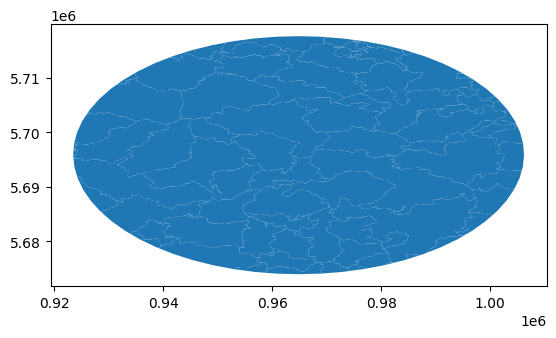

In [360]:
print(gdf_circle.geometry)
print(gdf_circle.crs)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# gdf_circle.plot(ax=ax, color='red', alpha=0.5)
gdf_circle.plot(ax=ax)
plt.show()
# # Plots
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots()
# # gdf_circle.plot(ax=ax, color='red', alpha=0.5)
# gdf_circle.plot(ax=ax)
# plt.show()

<Axes: >

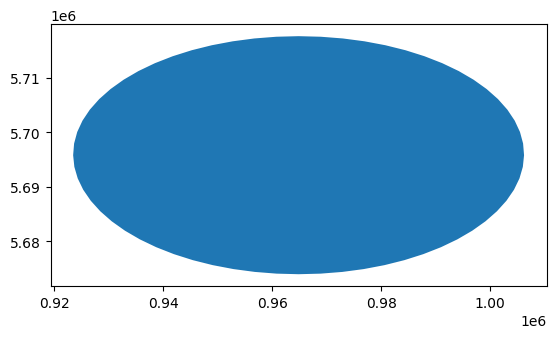

In [361]:
poly_merged = gdf_circle.geometry.union_all()
gdf = gpd.GeoSeries([poly_merged])
gdf_merged = gdf.to_frame(name='geometry').set_crs(epsg=6933)
gdf_merged.plot()

<Axes: >

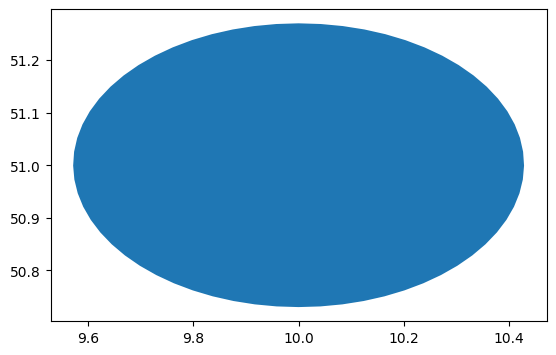

In [351]:
gdf_merged.geometry.plot()

In [328]:
dict_uni[4326]['gdf']

,OBJID,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,IBZ,...,PERC_int,EWZ_int,EWZ_out,EWZ_sum,EWZ_ref,EWZ_perc,KFL_sum,KFL_out,KFL_ref,KFL_perc
0,DEBKGVG20000024Z,6,4,1,066310007007,06631007,066310007007,Eiterfeld,Gemeinde,62,...,0.5793,322275,104901,427176,427176,75.44,4025.7,-2743.45,3979,70.38
1,DEBKGVG20000025E,6,4,1,066310022022,06631022,066310022022,Rasdorf,Gemeinde,62,...,0.1823,322275,104901,427176,427176,75.44,4025.7,-2802.98,3979,70.38
2,DEBKGVG20000025G,6,4,1,066320001001,06632001,066320001001,Alheim,Gemeinde,62,...,0.9988,322275,104901,427176,427176,75.44,4025.7,-2769.02,3979,70.38
3,DEBKGVG20000025H,6,4,1,066320002002,06632002,066320002002,Bad Hersfeld,Stadt,61,...,0.8560,322275,104901,427176,427176,75.44,4025.7,-2759.32,3979,70.38
4,DEBKGVG20000025I,6,4,1,066320003003,06632003,066320003003,Bebra,Stadt,61,...,1.0000,322275,104901,427176,427176,75.44,4025.7,-2739.29,3979,70.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,DEBKGVG20000083U,6,4,1,160645053032,16064032,160645053032,Kammerforst,Gemeinde,64,...,0.2183,322275,104901,427176,427176,75.44,4025.7,-2817.47,3979,70.38
79,DEBKGVG20000083V,6,4,1,160645053053,16064053,160645053053,Oppershausen,Gemeinde,64,...,0.1894,322275,104901,427176,427176,75.44,4025.7,-2824.59,3979,70.38
80,DEBKGVG20000083W,6,4,1,160645053075,16064075,160645053075,Vogtei,Gemeinde,64,...,0.1776,322275,104901,427176,427176,75.44,4025.7,-2783.53,3979,70.38
81,DEBKGVG20000083Y,6,4,1,160645054076,16064076,160645054076,Unstrut-Hainich,Gemeinde,64,...,0.0326,322275,104901,427176,427176,75.44,4025.7,-2736.44,3979,70.38


In [294]:
epsg=4326
if epsg == 4326:
    epsg_proj = 3857
else:
    epsg_proj = epsg
gdf_de_uni = gpd.overlay(dict_gdf_de[epsg].to_crs(epsg=epsg_proj), dict_epsg[epsg]['gdf'].to_crs(epsg=epsg_proj), \
                            how='intersection').drop(l_cols_non_serializable,axis=1)

gdf_de_uni

,OBJID,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,IBZ,...,EWZ,KFL,DLM_ID,EPK,EPK_norm,KFL_GPD,lat,lon,area,geometry
0,DEBKGVG20000024Z,6,4,1,066310007007,06631007,066310007007,Eiterfeld,Gemeinde,62,...,7110,89,DEBKGDL20000DX6F,79.887640,0.0,223.75,50.764393,9.815881,7143.85,"POLYGON ((1087994.678 6586973.082, 1088025.446..."
1,DEBKGVG20000025E,6,4,1,066310022022,06631022,066310022022,Rasdorf,Gemeinde,62,...,1581,30,DEBKGDL20000DW64,52.700000,0.0,75.01,50.717124,9.897403,7143.85,"POLYGON ((1106560.513 6576787.831, 1106537.936..."
2,DEBKGVG20000025G,6,4,1,066320001001,06632001,066320001001,Alheim,Gemeinde,62,...,4959,63,DEBKGDL20000DZ4F,78.714286,0.0,161.75,51.028815,9.659455,7143.85,"POLYGON ((1082846.422 6634524.86, 1083393.238 ..."
3,DEBKGVG20000025H,6,4,1,066320002002,06632002,066320002002,Bad Hersfeld,Stadt,61,...,30652,73,DEBKGDL20000E26A,419.890411,0.0,184.94,50.865028,9.701212,7143.85,"POLYGON ((1080798.332 6603889.759, 1081398.349..."
4,DEBKGVG20000025I,6,4,1,066320003003,06632003,066320003003,Bebra,Stadt,61,...,13983,93,DEBKGDL20000DW4J,150.354839,0.0,236.30,50.977940,9.815296,7143.85,"POLYGON ((1093425.123 6627516.121, 1093867.944..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,DEBKGVG20000083U,6,4,1,160645053032,16064032,160645053032,Kammerforst,Gemeinde,64,...,816,16,DEBKGDL20000DXN8,51.000000,0.0,39.58,51.118561,10.414555,7143.85,"POLYGON ((1156782.713 6638937.882, 1156775.065..."
79,DEBKGVG20000083V,6,4,1,160645053053,16064053,160645053053,Oppershausen,Gemeinde,64,...,287,8,DEBKGDL20000DXGM,35.875000,0.0,21.56,51.134500,10.412523,7143.85,"POLYGON ((1155517.363 6642324.27, 1155425.833 ..."
80,DEBKGVG20000083W,6,4,1,160645053075,16064075,160645053075,Vogtei,Gemeinde,64,...,4260,49,DEBKGDL20000U8J2,86.938776,0.0,125.83,51.159551,10.394271,7143.85,"MULTIPOLYGON (((1154044.925 6644319.664, 11534..."
81,DEBKGVG20000083Y,6,4,1,160645054076,16064076,160645054076,Unstrut-Hainich,Gemeinde,64,...,5187,94,DEBKGDL200015MZ7,55.180851,0.0,245.01,51.124963,10.511099,7143.85,"MULTIPOLYGON (((1159347.312 6632827.968, 11592..."


In [ ]:
_ih[-5:]

['',
 'get_ipython().run_line_magic(\'cd\', \'"C:\\\\\\\\Code\\\\\\\\ditto_v2"\')',
 "get_ipython().run_line_magic('pwd', '')",
 'get_ipython().run_line_magic(\'cd\', \'"C:\\\\\\\\Code\\\\\\\\ditto_v2"\')',
 "get_ipython().run_line_magic('pwd', '')",
 '# Define the center point and radius\nlat, lon = 0.0, 0.0  # Example coordinates\nradius_km = 30\nradius = radius_km * 1000  # Convert km to meters',
 "from shapely.geometry import Point\nimport geopandas as gpd\n\n## GeoDataFrame with Germany's state boundaries\ngdf_de = gpd.read_file('JupNB\\DE_Data\\VG250_GEM_WGS84.shp')\n\n\n# Create a point object\npoint = Point(lon, lat)\n\nresult = gdf_de.geometry.contains(point)\ngdf_point = gdf_de[result]\n\nif gdf_point.empty:\n    print('No data found')\nelse:\n    print(f'shape={gdf_point.shape}')\n    \n# Plots\nimport matplotlib.pyplot as plt\nfig, ax = plt.subplots()\n# gdf_circle.plot(ax=ax, color='red', alpha=0.5)\ngdf_de.plot(ax=ax)\nplt.show()",
 "l_epsg = [6933, \n          3857,    #

In [431]:
gdf_int = dict_int[4326]['gdf']
gdf_int.head(5)

,OBJID,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,IBZ,...,DLM_ID,EPK,EPK_norm,geometry,KFL_GPD,lat,lon,index_right,area,distance_km
2765,DEBKGVG20000024Z,6,4,1,066310007007,06631007,066310007007,Eiterfeld,Gemeinde,62,...,DEBKGDL20000DX6F,79.887640,0.0,"POLYGON ((6764621.536 6927298.156, 6764886.345...",89.64,50.764393,9.815881,0,7143.85,9.680
2780,DEBKGVG20000025E,6,4,1,066310022022,06631022,066310022022,Rasdorf,Gemeinde,62,...,DEBKGDL20000DW64,52.700000,0.0,"POLYGON ((6773215.059 6937955.816, 6773418.652...",30.11,50.717124,9.897403,0,7143.85,9.693
2782,DEBKGVG20000025G,6,4,1,066320001001,06632001,066320001001,Alheim,Gemeinde,62,...,DEBKGDL20000DZ4F,78.714286,0.0,"POLYGON ((6735800.414 6929727.866, 6735843.167...",64.07,51.028815,9.659455,0,7143.85,9.657
2783,DEBKGVG20000025H,6,4,1,066320002002,06632002,066320002002,Bad Hersfeld,Stadt,61,...,DEBKGDL20000E26A,419.890411,0.0,"POLYGON ((6753646.721 6924543.954, 6753825.269...",73.77,50.865028,9.701212,0,7143.85,9.669
2784,DEBKGVG20000025I,6,4,1,066320003003,06632003,066320003003,Bebra,Stadt,61,...,DEBKGDL20000DW4J,150.354839,0.0,"POLYGON ((6741178.063 6935403.854, 6741394.706...",93.80,50.977940,9.815296,0,7143.85,9.669


In [432]:
center_point.y, center_point.x

(51.0, 10.0)

In [433]:
gdf_int.geometry

2765     POLYGON ((6764621.536 6927298.156, 6764886.345...
2780     POLYGON ((6773215.059 6937955.816, 6773418.652...
2782     POLYGON ((6735800.414 6929727.866, 6735843.167...
2783     POLYGON ((6753646.721 6924543.954, 6753825.269...
2784     POLYGON ((6741178.063 6935403.854, 6741394.706...
                               ...                        
10501    POLYGON ((6739630.65 6983216.967, 6740031.207 ...
10502    MULTIPOLYGON (((6738445.168 6982943.563, 67386...
10503    POLYGON ((6732632.51 6975842.3, 6733836.777 69...
10505    POLYGON ((6736062.576 6994116.675, 6736330.755...
10572    POLYGON ((6775649.994 6967391.747, 6775806.32 ...
Name: geometry, Length: 83, dtype: geometry

In [434]:
gdf_int = gdf_int.to_crs(epsg=3310)#, inplace=True)
distances = gdf_int.geometry.apply(lambda g: center_point.distance(g))

# Add the distances as a new column in the GeoDataFrame
gdf_int['distance_km'] = round(distances / 10**6,3)
gdf_int.head(5)

,OBJID,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,IBZ,...,DLM_ID,EPK,EPK_norm,geometry,KFL_GPD,lat,lon,index_right,area,distance_km
2765,DEBKGVG20000024Z,6,4,1,066310007007,06631007,066310007007,Eiterfeld,Gemeinde,62,...,DEBKGDL20000DX6F,79.887640,0.0,"POLYGON ((6764621.536 6927298.156, 6764886.345...",89.64,50.764393,9.815881,0,7143.85,9.680
2780,DEBKGVG20000025E,6,4,1,066310022022,06631022,066310022022,Rasdorf,Gemeinde,62,...,DEBKGDL20000DW64,52.700000,0.0,"POLYGON ((6773215.059 6937955.816, 6773418.652...",30.11,50.717124,9.897403,0,7143.85,9.693
2782,DEBKGVG20000025G,6,4,1,066320001001,06632001,066320001001,Alheim,Gemeinde,62,...,DEBKGDL20000DZ4F,78.714286,0.0,"POLYGON ((6735800.414 6929727.866, 6735843.167...",64.07,51.028815,9.659455,0,7143.85,9.657
2783,DEBKGVG20000025H,6,4,1,066320002002,06632002,066320002002,Bad Hersfeld,Stadt,61,...,DEBKGDL20000E26A,419.890411,0.0,"POLYGON ((6753646.721 6924543.954, 6753825.269...",73.77,50.865028,9.701212,0,7143.85,9.669
2784,DEBKGVG20000025I,6,4,1,066320003003,06632003,066320003003,Bebra,Stadt,61,...,DEBKGDL20000DW4J,150.354839,0.0,"POLYGON ((6741178.063 6935403.854, 6741394.706...",93.80,50.977940,9.815296,0,7143.85,9.669


In [ ]:
# Convert the Shapely circle to a GeoSeries
gdf = gpd.GeoSeries([circle_poly])

# Convert the GeoSeries to a GeoDataFrame
gdf = gdf.to_frame(name='geometry')

<GeometryArray>
[<POLYGON ((0.121 42, 0.12 41.991, 0.119 41.982, 0.116 41.974, 0.112 41.966, ...>]
Length: 1, dtype: geometry

In [ ]:

print(f'lat={lat}, lon={lon}')
circle = geometry.Point(lat, lon).buffer(radius)
circle#point_3857.geometry.values[0].exterior.coords.xy


center_point = geometry.Point(lon, lat)
gdf = gpd.GeoDataFrame(geometry=[center_point], crs=CRS.from_epsg(3857))
point_3857 = gdf.buffer(radius)



lat=42, lon=0


In [ ]:
.geo

,geometry,area
0,"POLYGON ((0.12718 44.99993, 0.12655 44.99112, ...",6.287170e+08


In [234]:

# transformer = Transformer.from_crs(4326, 3857, always_xy=True)
# point00 = Point(0,0)
# gdf_cir_3857 = point00.buffer(radius)
# print(f'point_3857={point_3857}')

# # List of points to transform
# points = [(22.95, 40.63), (22.81, 40.53), (23.51, 40.86)]
# transformed_points = [transformer.transform(*pt) for pt in points]

# transformer2 = Transformer.from_crs(3857, 4326, always_xy=True)
# center_point = Point(point_3857[0],point_3857[1])
# gdf_point = gpd.GeoDataFrame(geometry=[center_point], crs=3857)

# gdf.set_geometry(gdf_cir.geometry.apply(lambda row: transformer2.transform(row.geometry)))

lat = 51
lon = 10
radius = 10000

fg_point = folium.FeatureGroup(name=f'Center point [lat={lat}, lon={lon}]')
folium.Marker([lat, lon], icon=folium.Icon(color="red")).add_to(fg_point)


poly_circle = circle_around_lat_lon_point(lon, lat, radius)
# Convert the Shapely circle to a geoDataFrame
gdf = gpd.GeoSeries([poly_circle])
gdf = gdf.to_frame(name='geometry').set_crs(epsg=4326)
gdf['area'] = gdf.to_crs(epsg=3857).geometry.area.sum()
# Generate FeatureGroup and add geojson
fg_circle = folium.FeatureGroup(name=f'Circle, EPSG=4326 [r={radius_km} Km]')
folium.GeoJson(gdf, color='green').add_to(fg_circle)   

###############  MAP  ##########################
print('Generating map...')
m = folium.Map()
m.add_child(fg_point)
m.add_child(fg_circle)

# # fg_mark.add_to(m)
# folium.LatLngPopup().add_to(m)
m.add_child(folium.LatLngPopup())
m.fit_bounds(m.get_bounds())

folium.LayerControl(position='topright',
                        collapsed=False).add_to(m)
m

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return type(geom)(zip(*func(*zip(*geom.coords))))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))


Generating map...


Bounding coordinates: (49.730203518224386, 9.580268981831177) to (50.26979648177562, 10.419731018168823)


In [ ]:

newport_ri = (51,10)
cleveland_oh = (51, 10.4288)
print(geodesic(newport_ri, cleveland_oh).miles)
# 538.390445368

18.70372136619885


In [ ]:
dict_epsg[3857]['gdf']['geometry'].to_crs(epsg=4326).bounds

In [ ]:
dict_epsg[6933]['gdf']['geometry'].to_crs(epsg=4326).bounds#['maxx'].values[0]

In [31]:
newport_ri = (50,10)
cleveland_oh = (50.26970737958123, 10.0)
print(geodesic(newport_ri, cleveland_oh).miles)
# 538.390445368

18.641135767119685


In [30]:
from geopy.distance import geodesic

latitude=50.0
longitude=10.0
# Define the center point of the circle
center_point = (latitude, longitude)

# Define the radius of the circle in kilometers
radius_km = 30

# Generate points around the circle
points = []
for angle in range(0, 360, 10):  # Generate points every 10 degrees
    point = geodesic(kilometers=radius_km).destination(center_point, angle)
    points.append((point.latitude, point.longitude))

print(points)

[(50.26970737958123, 10.0), (50.265587108305034, 10.07306348510954), (50.25335356414034, 10.143870234869228), (50.23338443223609, 10.210236607219079), (50.20629559969213, 10.270122354926418), (50.1729213170942, 10.321695504301479), (50.13428747992733, 10.363389485363504), (50.09157901321692, 10.393950608104275), (50.046102529014604, 10.412474476021062), (49.99924555434487, 10.41843045805327), (49.95243369578423, 10.411673862394691), (49.907087119089375, 10.392445935609382), (49.86457768467128, 10.361362222762148), (49.82618800079376, 10.31939015447835), (49.79307354558758, 10.267816971206349), (49.766228875519886, 10.20820925878764), (49.74645878998315, 10.142365464771965), (49.73435516570344, 10.07226280777774), (49.73028001542462, 10.0), (49.73435516570344, 9.92773719222226), (49.74645878998315, 9.857634535228035), (49.766228875519886, 9.79179074121236), (49.79307354558758, 9.732183028793651), (49.82618800079376, 9.68060984552165), (49.86457768467128, 9.638637777237852), (49.90708711

In [ ]:
# import haversine as hs
# from haversine import Unit

# result = hs.haversine(loc1, loc2, unit=Unit.KILOMETERS)
# gdf_de_int['dist_km'] = gdf_de_int.apply(lambda row: Point(row.longitude, row.latitude), axis=1)
gdf_de_int['dist1'] = gdf_de_int.geometry.distance(center_point) / 1000#).round(2)
# epsg = l_epsg[0]
# print(f'epsg={epsg}')
# gdf_de_int = gpd.sjoin(dict_gdf_de[epsg], dict_epsg[epsg]['gdf'], how="inner", predicate="intersects").drop(l_cols_non_serializable, axis=1)
# print(f'gdf_de_int.shape()={gdf_de_int.shape}')

gdf_de_int_3857 = gdf_de_int.to_crs('EPSG:3310')
gdf_point_3857 = gdf_point.to_crs('EPSG:3310')
distances = gdf_de_int_3857.geometry.distance(gdf_point_3857)

# # Add the distances as a new column in the GeoDataFrame
# gdf_de_int['distance_km'] = round(distances / 10**6,3)
gdf_de_int_3857.head(2)

In [ ]:
gem = 'Riedenberg'
lat_ar = gdf_de_int[gdf_de_int['GEN'] == gem]['lat'].values[0]
lon_ar = gdf_de_int[gdf_de_int['GEN'] == gem]['lon'].values[0]
print(f'lat_ar={lat_ar}, lon_ar={lon_ar}')

In [326]:
from geopy.distance import geodesic

# coord_30k_6933 = (50.0364, 10.2633)
coord_30k_6933 = (51, 10)
coord_30k_3857 = (  51, 10.4288)
# coords_1 = (lat_ar, lon_ar)
coords_2 = (51, 10)
distance1 = geodesic(coord_30k_6933, coords_2).meters
distance2 = geodesic(coord_30k_3857, coords_2).meters
print(f"Distance1= {distance1} m")
print(f"Distance2= {distance2} m")

Distance1= 0.0 m
Distance2= 30100.72175836392 m


In [ ]:
center_point.x,  center_point.y

In [ ]:
#%pip install haversine
import haversine as hs
from haversine import Unit

result = hs.haversine(coord_30k_6933, coords_2, unit=Unit.KILOMETERS)
result

In [ ]:
epsg = 6933
gpd_de_diff = gpd.overlay(gdf_de_uni.iloc[0:1], dict_epsg[epsg]['gdf'], how='union')
gpd_de_diff = gpd_de_diff.dropna().drop_duplicates()
gpd_de_diff
# fgd = f_maps.get_folium_featuregroup(gpd_de_diff, fg_name=f'Dif EPSG ={epsg} [#={gpd_de_diff.shape[0]}]',
#                                         fields=['GEN', 'EWZ', 'KFL', 'AGS'],
#                                         aliases = ['Name', 'Population', 'Area', 'AGS'])



# m = folium.Map
# m.add_child(fgd)
# m

In [79]:
import geopandas as gpd
import folium
from shapely import geometry
from pyproj import CRS
from src.functionality_maps import f_maps



## GeoDataFrame with Germany's state boundaries
gdf_de = gpd.read_file('JupNB\DE_Data\VG250_GEM_WGS84.shp')


############ CIRCLE ############
# Create a geopandas GeoDataFrame with the center point
center_point = geometry.Point(lon, lat)
gdf = gpd.GeoDataFrame(geometry=[center_point], crs=CRS.from_epsg(4326))
circle_30k_4326 = gdf.buffer(radius)
circle_30k_4326 = circle_30k_4326.to_crs(epsg=4326)

gdf_6933 = gdf.to_crs(epsg=6933)                         # Convert the point to the projected CRS
circle_6933 = gdf_6933.buffer(radius)                  # Buffer the point by the specified radius
circle_4326 = circle_6933.to_crs(epsg=4326)         # Convert the circle back to the geographic CRS
circle_3857 = circle_6933.to_crs(epsg=3857)         # Convert the circle back to the geographic CRS


gjson_circle_30k_4326 = folium.GeoJson(circle_30k_4326, color='red')
fg_gjson_circle_30k_4326 = folium.FeatureGroup(name=f'Circle 4326 30K [r={radius_km}]')
gjson_circle_30k_4326.add_to(fg_gjson_circle_30k_4326)


gjson_circle_6933 = folium.GeoJson(circle_6933, color='red')
fg_circle_6933 = folium.FeatureGroup(name=f'Circle 6933 [r={radius_km}]')
gjson_circle_6933.add_to(fg_circle_6933)

# # Create a folium Feature Group with the GeoJson object
gjson_circle_4326 = folium.GeoJson(circle_4326, color='green')
fg_circle_4326 = folium.FeatureGroup(name=f'Circle 4326 [r={radius_km}]')
gjson_circle_4326.add_to(fg_circle_4326)


gjson_circle_3857 = folium.GeoJson(circle_3857, color='green')
fg_circle_3857 = folium.FeatureGroup(name=f'Circle 3857 [r={radius_km}]', color='red')
gjson_circle_3857.add_to(fg_circle_3857)

# fg_circle = f_maps.get_folium_featuregroup(gdf_circle, fg_name=f'Circle [{radius_km} km]')




############ CONTAINS POINT ############
result = gdf_de.geometry.contains(center_point)     # Find the geometry that contains a point
gdf_de_point = gdf_de[result]                       # Create a GeoDataFrame with the point
gdf_de_point = gdf_de_point.drop(['WSK','BEGINN'], axis=1) # Remove timestamp columns (not serializable)

# gj_de_point = folium.GeoJson(gdf_de_point)                # Create a GeoJson object

# # Create a folium Feature Group with the GeoJson object
# fg_de_point = folium.FeatureGroup(
#     name=f'Germany GEM [{gdf_de_point.shape[0]}]',
#                             # tooltip=tooltip_de
#                             )
# fg_de_point.add_child(gj_de_point)

fgc = f_maps.get_folium_featuregroup(gdf_de_point, fg_name=f'Container point [{center_point}]',
                                       fields=['GEN', 'EWZ', 'KFL', 'AGS'],
                                       aliases = ['Name', 'Population', 'Area', 'AGS'])



# ############ GEOMETRY INTERSECTION ############
# # Find the intersection
# intersection = gpd.sjoin(gdf_de, gdf_circle, how="inner", predicate="intersects").drop(['WSK','BEGINN'], axis=1)
# intersection = gpd.sjoin(gdf_de, gdf_circle, how="inner", predicate="intersects").drop(['WSK','BEGINN'], axis=1)
# fgi = f_maps.get_folium_featuregroup(intersection, fg_name='Intersection',
#                                        fields=['GEN', 'EWZ', 'KFL', 'AGS'],
#                                        aliases = ['Name', 'Population', 'Area', 'AGS'])


# # gji = folium.GeoJson()
# # # Create a folium Feature Group with the GeoJson object
# # fgi = folium.FeatureGroup(
# #     name=f'GJI [{intersection.shape[0]}]',
# #                             # tooltip=tooltip_de
# #                             )
# # fgi.add_child(gji)


# # Create a GeoDataFrame with the intersection
# gdf_int = gdf_de[gdf_de.index.isin(intersection.index)]
# # gdf_int = gdf_int.reset_index(drop=True)
# gdf_int = gdf_int.drop(['WSK','BEGINN'], axis=1) # Remove timestamp columns (not serializable)
# fgi2 = f_maps.get_folium_featuregroup(gdf_int, fg_name='Intersection 2',
#                                        fields=['GEN', 'EWZ', 'KFL', 'AGS'],
#                                        aliases = ['Name', 'Population', 'Area', 'AGS'])

# gj_int = folium.GeoJson(gdf_int)                # Create a GeoJson object

# # Create a folium Feature Group with the GeoJson object
# fg_int = folium.FeatureGroup(
#     name=f'Intersection [{gdf_int.shape[0]}]',
#                             # tooltip=tooltip_de
#                             )
# fg_int.add_child(gj_int)

### GEOMETRY UNION ###
# ide = gpd.overlay(gdf_de,gdf_circle, how='union')

# Create a folium map
m = folium.Map(location=[32.134755, 74.175929], zoom_start=10)
# m.add_child(fg_gjson_circle_30k_4326)
m.add_child(fg_circle_6933)
m.add_child(fg_circle_4326)
m.add_child(fg_circle_3857)
# m.add_child(fgc)
# m.add_child(fgi)
# m.add_child(fgi2)
# m.fit_bounds(m.get_bounds())

folium.LayerControl(position='topright',
                        collapsed=False).add_to(m)
m

<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
C:\Users\User\AppData\Local\Temp\ipykernel_13216\3002014784.py:10: SyntaxWarning: invalid escape sequence '\D'
  gdf_de = gpd.read_file('JupNB\DE_Data\VG250_GEM_WGS84.shp')
C:\Users\User\AppData\Local\Temp\ipykernel_13216\3002014784.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  circle_30k_4326 = gdf.buffer(radius)


### Areas

In [ ]:
intersection.geometry.area.sum()

In [ ]:
import math
area_logical = math.pi * 30 * 30
area_6933 = circle_6933.area.sum() / 10**6
# area_4326 = circle_4326.area.sum() / 10**6
circle_3857 = circle_4326.to_crs(epsg=3857) 
area_3857 = circle_3857.area.sum()/ 10**6

print(f'area_logical = {area_logical}')
print(f'area_6933 = {area_6933}')
# print(f'area_4326 = {area_4326}')

print(f'area_3857 = {area_3857}')


In [ ]:
print(f' ')

In [ ]:
# Projection to a planar CRS (6933) that preserves area
intersection_6933 = intersection.to_crs(epsg=6933)
intersection_area = intersection_6933.geometry.area.sum() / 10**6 
area_int = round(intersection_area,2)

# intersection_4326 = intersection.geometry.area.sum() / 10**6 
# area_4326 = round(intersection_4326,2)

area_cir = round(circle_6933.area.sum() / 10**6,2)
perc_area = area_cir / intersection_area
area_per = round(100*perc_area, 2)

gdf_circle_6933 = gdf_circle.to_crs(epsg=6933)
gdf_union_6933 = gpd.overlay(intersection_6933, gdf_circle_6933, how='intersection')
union_area = gdf_union_6933.geometry.area.sum() / 10**6 
area_uni = round(union_area,2)


print(f' Area Intersection in Km - computed = {area_int} km2')  # Area in square kilometers
print(f' Area Intersection in Km - data = {intersection.KFL.sum()} km2')  # Area in square kilometers
print(f' Area of Circle in Km = {area_cir} km2')  # Area in square kilometers
print(f' Area Union in Km - data = {area_uni} km2')  # Area in square kilometers
print(f' Area Percentage in Km = {area_per}%')  # Area in square kilometers


In [ ]:
# intersection_3857 = intersection_3857.drop(['WSK','BEGINN'], axis=1) # Remove timestamp columns (not serializable)

# Projection to a Pseudo-Mercator (3857) used for visualization
fgi_3857 = f_maps.get_folium_featuregroup(intersection_3857, fg_name=f'Intersection [{area_int}/{intersection_3857.KFL.sum()} km2]',
                                       fields=['GEN', 'KFL', 'AGS'],
                                       aliases = ['Name', 'Area', 'AGS'])

# Projection to a planar CRS (6933) that preserves area
fgi_6933 = f_maps.get_folium_featuregroup(intersection_6933, fg_name=f'Intersection [{area_int}/{intersection_6933.KFL.sum()} km2]',
                                       fields=['GEN', 'KFL', 'AGS'],
                                       aliases = ['Name', 'Area', 'AGS'])

# # Projection to WGS-84 (4326) [Areas can NOT BE COMPUTED]
# fgi_4326 = f_maps.get_folium_featuregroup(intersection_4326, fg_name=f'Intersection [{area_int} km2]',
#                                        fields=['GEN', 'KFL', 'AGS'],
#                                        aliases = ['Name', 'Area', 'AGS'])

fgu = f_maps.get_folium_featuregroup(gdf_union_6933, fg_name=f'Union [{area_uni} km2]',
                                       fields=['GEN', 'KFL', 'AGS'],
                                       aliases = ['Name', 'Area', 'AGS'])

m=folium.Map()
m.add_child(fgi_3857)
# m.add_child(fgi_6933)
# m.add_child(fgi_4326)
m.add_child(fg_circle_3857)
# m.add_child(fg_circle_4326)
# m.add_child(fg_circle_6933)

m.add_child(fgu)
m.fit_bounds(m.get_bounds())

folium.LayerControl(position='topright',
                        collapsed=False).add_to(m)
m

In [ ]:
gdf_wue = gdf_int[gdf_int['GEN'] == 'Würzburg']
gdf_wue = gdf_wue.to_crs(epsg=6933)
gdf_area = gdf_wue.geometry.area.sum() / 10**6

print(f'Computed area Wuerzburg [{gdf_area} km2]')
print(f'Provided area Wuerzburg [{gdf_wue.KFL.sum()} km2]')

### Apply operation to gdf

In [ ]:
gdf_de.head(1)

In [ ]:
fg_de = f_maps.get_folium_featuregroup(gdf_de, fg_name='Germany GEM',
                                       fields=['GEN', 'EWZ', 'KFL', 'AGS'],
                                       aliases = ['Name', 'Population', 'Area', 'AGS'])
fg_circle = f_maps.get_folium_featuregroup(circle_4326, fg_name=f'Circle [{radius_km} km]')
m = folium.Map()
m.add_child(fg_de)
m.add_child(fg_circle)

m.fit_bounds(m.get_bounds())

folium.LayerControl(position='topright',
                        collapsed=False).add_to(m)
m


### Intersection visualization

In [ ]:
gdf_int

In [ ]:


gdf_int_6933 = gdf_int.to_crs(epsg=6933)
gdi = gpd.overlay(gdf_int_6933.iloc[0:1], gdf_union_6933, how='intersection')
gj0 = folium.GeoJson(gdi) 
fg0 = folium.FeatureGroup(name=f'GDI Iloc0 ')#[{gdi.KFL.values}]',color='red')

m=folium.Map()
m.add_child(fg0)
m.add_child(fgu)
m.fit_bounds(m.get_bounds())

folium.LayerControl(position='topright',
                        collapsed=False).add_to(m)
m

In [ ]:
gdi = gpd.overlay(gdf_int.iloc[0:1], gdf_circle, how='intersection')
gj0 = folium.GeoJson(gdi) 
fg0 = folium.FeatureGroup(name=f'GDI Iloc0 [{gdi.KFL.values}]',)
fg0.add_child(gj0)

gde = gdf_int.iloc[0:1]
gje = folium.GeoJson(gde) 
fge = folium.FeatureGroup(name=f'GDE Iloc0[{gde.KFL.values}]',)
fge.add_child(gje)


m2 = folium.Map()
m2.add_child(fg0)
m2.add_child(fg_circle)
m2.add_child(fge)
m2.fit_bounds(m2.get_bounds())
folium.LayerControl(position='topright',
                        collapsed=False).add_to(m2)
m2

In [ ]:
area_perc_4326 = 100 * round(gdi.area.values[0]/gde.area.values[0], 4)

gdi_3857 = gdi.to_crs(epsg=3857)
gde_3857 = gde.to_crs(epsg=3857)

area_perc_3857 = 100 * round(gdi_3857.area.values[0]/gde_3857.area.values[0], 4)
print(f'area_perc_4326 ={area_perc_4326}, area_perc_3857 ={area_perc_3857}')

In [ ]:
gde_3857.area

In [ ]:
gde.area

In [ ]:
gdi.area

In [ ]:
gde.iloc[0]

In [ ]:
print(f'interval area = {gdi.area.values[0]}')
print(f'interval area = {gde.area.values[0]}')

In [ ]:
# gdf_int.contains(circle_4326)
# Convert the GeoSeries to a GeoDataFrame
# gdf_circle = gpd.GeoDataFrame(geometry=circle_4326)

gdf_union_3857 = gpd.overlay(gdf_int_3857,gdf_circle_3857, how='intersection')
gdf_union_4326 = gdf_union_3857.to_crs(epsg=4326)
gj_union = folium.GeoJson(gdf_union_4326) 
m2 = folium.Map()
m2.add_child(gj_union)
m2.fit_bounds(m2.get_bounds())
m2

In [ ]:
# Find the intersection between the polygon and each row
intersection = gdf_de_point.intersection(gdf_circle.geometry)
intersection.area

In [ ]:
# Save geometries to another field
gdf_int['geom'] = gdf_int.geometry

# Self join
sj = gpd.sjoin(gdf_int, gdf_int, 
               how="inner", predicate="intersects", 
               lsuffix="left", rsuffix="right")

# Remove self-intersections
sj = sj[sj.index != sj.index_right]

# Extract the intersecting geometry
sj['intersection_geom'] = sj['geom_left'].intersection(sj['geom_right'])

# Reset the geometry
sj.set_geometry('intersection_geom', drop=True, inplace=True, crs=gdf.crs)

# Drop duplicate geometries
final_gdf = sj.drop_duplicates(subset=['geometry']).reset_index()

# Drop intermediate fields
drops = ['geom_left', 'geom_right', 'index_right', 'index']
final_gdf = final_gdf.drop(drops, axis=1)

In [ ]:
import folium
m = folium.Map()
m.add_child(folium.GeoJson(gdf_circle.to_json()))
m.fit_bounds(gdf_circle.total_bounds)
m

In [ ]:
# Create a GeoDataFrame for the points
points = gpd.GeoDataFrame(geometry=[point])

# Perform a spatial join to find points within polygons
result = gpd.sjoin(points, polygons, how="inner", op="within")